# Measure and improve


All these weeks we were exploring different ways to build a search engine: based on vectors, graphs, trees. We were adding new features such as spell-checking and suggest. This all might seem good, however, we have no ways to tell if our changes were indeed enhancements. How do we know that search engine's quality haven't deteriorated because of our changes? How do we know if cosine scoring is better than okapi scoring? How can we check if applying language models instead of vector-space models is beneficial? 

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. Normalized Discounted Cumulative Gain (NDCG)
3. 11-Point Interpolated Average

We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.  

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.


## Data

There is a number of ways to evaluate a search engine, however, all of them require so called relevance judgements - human assigned scores of relevance between query-doc_id pairs. We will use Cranfield relevance judgements collection, download it from [here](https://drive.google.com/drive/folders/1u6dSUqdrXsckSHmVHNNE27eDiajMWLl2?usp=sharing). 

This was the pioneering test collection in allowing precise quantitative measures of information retrieval effectiveness, but is nowadays too small for anything but the most elementary pilot experiments (which is exactly what we are doing here). Collected in the United Kingdom starting in the late 1950s, it contains 1400 abstracts of aerodynamics journal articles, a set of 225 queries, and exhaustive relevance judgments of all (query, document) pairs.

![image.png](attachment:image.png)


It comes in a json format, the detailed description is available in the readme file.


In [0]:
import json

def read_cranfield(path):
    with open("cranqrel.json", "r") as read_file:
      rele = json.load(read_file)
    with open("cranfield_data.json", "r") as read_file:
      cranfield = json.load(read_file)
    with open("cran.qry.json", "r") as read_file:
      qry = json.load(read_file)
    # TODO: read the cranfield data
    # relevance should be a dictionary, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    documents = {}
    queries = {}
    relevance = {}
    for i in rele:
      # relevance[i['query_num']] = i['position']
      relevance.setdefault(int(i['query_num']),[]).append((int(i['id']),i['position']))
    for i in qry:
      queries[i['query number']] = i['query']
    for i in cranfield:
      documents[i['id']] = i['body']
    return documents, queries, relevance

cran_orig_path = 'cranfield_data/'
documents, queries, relevance = read_cranfield(cran_orig_path)

### Test 

In [0]:
assert len(documents) == 1400 
assert len(relevance) == 225

## 1. Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top k documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). That is, if the set of relevant documents for an information need q<sub>j</sub> ∈ Q is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.


In [0]:
def mean_avg_precision(search_results, relevance):
    # TODO: calculate MAP score for search results, treating relevance judgments as binary - either relevant or not.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    

    overall_prec = 0
    for counte, b in enumerate (search_results):
      # list of relevant search results
      results = []
      for g in relevance[counte+1]:
        results.append(g[0])
      # number of elements after relevant
      counter = 0
      precision = 0
      right_finding = 0

      for g in b:
        counter+=1
        if g in results:
          right_finding+=1
          precision += right_finding/counter
      overall_prec+=precision/len(results)
    overall_prec=overall_prec/len(search_results)
    
    return overall_prec


### 1.1 Test

In [77]:
import numpy as np

test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285715


## 2. Normalized Discounted Cumulative Gain

There is also so called NDCG metric, which is designed for situations of non-binary notions of relevance. It is evaluated over some number *k* of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries Q, let *R(j,d)* be the relevance score assessors gave to document *d* for query *j*. Then,

![](https://i.imgur.com/LLogCYa.png)

where Z<sub>kj</sub> is a normalization factor calculated to make it so that a perfect ranking’s NDCG at *k* for query *j* is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

In [0]:
#fix score
test_relevance_n = dict(test_relevance)
for key,items in test_relevance_n.items():
  for numb, element in enumerate(items):
    items[numb] = (element[0],abs(element[1]-5))

In [0]:
import math 

#fixed test relevance
test_relevance_n = dict(test_relevance)
for key,items in test_relevance_n.items():
  for numb, element in enumerate(items):
    items[numb] = (element[0],abs(element[1]-5))


def NDCG(search_results, relevance):
    overall_prec = 0

    for counte, b in enumerate (search_results):
      # list of relevant search results
      results = []
      ranks = []
      for g in relevance[counte+1]:
        results.append(g[0])
        ranks.append(g[1])
      ranks.sort(reverse=True)

      # number of elements after relevant
      counter = 0
      precision = 0
      for g in b:
        counter+=1
        if g in results:
          position = results.index(g)
          precision+=((2** relevance[counte+1][position][1]) - 1)/math.log2(counter+1)
      #calculate normalizer and use it
      normalizer = 0
      counter = 0
      for element in ranks:
        counter+=1
        normalizer+=((2** element) - 1)/math.log2(counter+1)
      overall_prec+=precision/normalizer
  



    overall_prec=overall_prec/len(search_results)
    
    return overall_prec  

    # TODO: compute NDCG score for search results. Here relevance is not considered as binary - the bigger
    # the judgement score is, the more relevant is the document to a query. Because in our cranfield dataset relevance
    # judgements are presented in a different way (1 is most relevant, 4 is least), we will need to smth with it. 
    # The simplest is to invert it, replacing each score with (5-score). For example, if the score was 2, it becomes 5-2=3.
    # To find normalization factor for each query, think in this direction - for this particular query what would be an
    # ideal DCG score? What documents should have (ideally) been returned by the search engine to maximize the DCG score?
    # When you find it, just normalize the real DCG score by ideal DCG score, that's it.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    

In [110]:
li = []
li.extend([1,2,1,5,2,6,2])
li.sort(reverse=True)
li

[6, 5, 2, 2, 2, 1, 1]

### 2.1 Test

In [215]:
ndcg_test = NDCG(test_results, test_relevance_n)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance_n) < NDCG(test_results[5:10], test_relevance_n)

ndcg_test 0.6409675295633275


## 3. 11-Point Interpolated Average (Bonus task)

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def eleven_points_interpolated_avg(search_results, relevance, plot=True):
    # TODO: return 11-points interpolated average over all queries. Refer to chapter 8.4 for explanation.
    # First calculate values of precision-recall curve for each query, interpolate them, and average over all queries.
    # This function is intended to use when for each query all documents are scored until the last relevant element
    # is met. Treats relevance judgments as binary - either relevant or not.
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    # return: interpolated_avg, list of 11 values    
    
    return []

### 3.1  Test

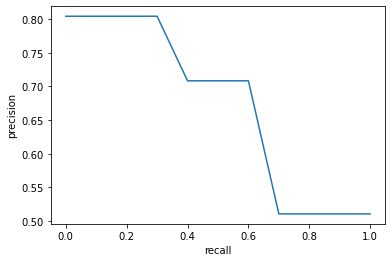

In [0]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 4. Evaluation

Now we want to apply these metrics and compare two ways of smoothing in ranking with language models. Since we only have relevance scores for Cranfield data, we will run search and do evaluations based on it.

### LM ranking

In [0]:
# TODO: copy here your lm_rank_documents function from the last lab

import numpy as np

def lm_rank_documents(query, tdm, terms_list, smoothing='additive', param=0.001):
    # TODO: score each document in tdm using this document's language model
    # implement two types of smoothing. Looks up term frequencies in tdm
    # return document scores in a convenient form
    # param is alpha for additive / lambda for jelinek-mercer
    """
    :param query: dict, term:count            
    :param tdm: term-document matrix
    :param terms_list: vocabulary list
    :param smoothing: which smoothing to apply, either 'additive' or 'jelinek-mercer'
    :param param: alpha for additive / lambda for jelinek-mercer
    :return: list of scores, list of doc_ids sorted by their scores 
    """
    n_docs = tdm.shape[0]
    doc_lengths = tdm.sum(axis=1)
    len_collection = np.sum(doc_lengths)
    scores = np.zeros(n_docs)
    for term in query.keys():
        # check if term exists
        if term in terms_list:
            # get term's id
            term_id = terms_list.index(term)
        else:
            continue
        query_tf = query[term]
        # calculate collection frequency of a term
        collection_tf = np.sum(tdm[:, term_id])
        for doc_id in range(n_docs):
            doc_tf = tdm[doc_id, term_id]
            # apply smoothing of any
            if smoothing == 'additive':
                doc_score_factor = (doc_tf + param) / (doc_lengths[doc_id] + param*len(terms_list))
            elif smoothing == 'jelinek':
                doc_score_factor = param*doc_tf/doc_lengths[doc_id] + (1-param)*collection_tf/len_collection
            else:
                doc_score_factor = doc_tf/doc_lengths[doc_id]
            doc_score_factor = doc_score_factor**query_tf

            if doc_id not in scores:
                scores[doc_id] = 1
            # accumulate scores
            scores[doc_id] *= doc_score_factor
    # sort doc_ids by scores
    sorted_doc_ids = np.argsort(-scores)
    return scores, sorted_doc_ids
  
def prepare_query(raw_query):
    # lower-case, remove punctuation and stopwords
    stop_words = list(string.punctuation) + stopwords.words('english')
    return Counter([i for i in word_tokenize(raw_query.lower()) if i not in stop_words])

In [177]:
#TDM
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from collections import Counter


vectorizer = CountVectorizer(stop_words='english')
counts_data = vectorizer.fit_transform(documents.values())
terms = vectorizer.get_feature_names()

query = []
for g in (queries.items()):
  query.append(g[1])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#fix relevance
relevance_n = dict(relevance)
for key,items in test_relevance_n.items():
  for numb, element in enumerate(items):
    items[numb] = (element[0],abs(element[1]-5))

In [0]:
#calculate lm_rank
jelly = []
additive = []
for dust in query[:210]:
  z = prepare_query(dust)
  g = lm_rank_documents(z, counts_data, terms, smoothing='additive', param=0.001)
  additive.append([x for _,x in sorted(zip(g[0],g[1]),reverse=True)][:100])
  g = lm_rank_documents(z, counts_data, terms, smoothing='jelinek', param=0.001)
  jelly.append([x for _,x in sorted(zip(g[0],g[1]),reverse=True)][:100])

In [0]:

jMAP = mean_avg_precision(jelly, relevance_n)
addMAP = mean_avg_precision(additive, relevance_n)


jNDCG =NDCG(jelly, relevance_n)
addNDCG = NDCG(additive, relevance_n)

### Additive smoothing VS Jelinek-Mercer smooting

In [254]:
# TODO: compare these two types of smoothing with evaluation metrics you've just impemented. Follow the output format given. 
print ("Evaluation results for additive smoothing:")
print ("MAP",addMAP)
print ("NDCG",addNDCG)
print ("Evaluation results for jelinek-mercer smoothing:")
print ("MAP",jMAP)
print ("NDCG",jNDCG)

Evaluation results for additive smoothing:
MAP 0.0035222725452724165
NDCG 0.022675757712156245
Evaluation results for jelinek-mercer smoothing:
MAP 0.003977674979927202
NDCG 0.020259763076952854
